# Eye of the Emergency

## Libraries and dataset import

In [1]:
# Data import & Exploring
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import seaborn as sns

# Text Processing
#import nltk
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('omw-1.4')

from sklearn.feature_extraction.text import TfidfVectorizer

# ML
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from xgboost import Booster

#Metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix

#Personalized
from fonctions import text_processing

In [2]:
train_df = pd.read_csv('train_tweets.csv')
test_df = pd.read_csv('test_tweets.csv')

## Data Preprocess

Recherche des tweets doublons

In [3]:
unique_count = pd.DataFrame(pd.value_counts(train_df.text))
unique_count = unique_count.reset_index()
unique_count.columns = ['text', 'count']

In [4]:
unique_count.head()

,text,count
0,11-Year-Old Boy Charged With Manslaughter of T...,10
1,He came to a land which was engulfed in tribal...,6
2,The Prophet (peace be upon him) said 'Save you...,6
3,#Bestnaijamade: 16yr old PKK suicide bomber wh...,6
4,Madhya Pradesh Train Derailment: Village Youth...,5


In [5]:
train_df_unique = pd.DataFrame(train_df.text.unique(), columns = ['text'])

In [6]:
train_df_unique.head()

,text
0,Our Deeds are the Reason of this #earthquake M...
1,Forest fire near La Ronge Sask. Canada
2,All residents asked to 'shelter in place' are ...
3,"13,000 people receive #wildfires evacuation or..."
4,Just got sent this photo from Ruby #Alaska as ...


In [7]:
train_df_unique = train_df_unique.merge(unique_count)

In [8]:
train_df_unique.head()

,text,count
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [9]:
train_df_count = train_df.merge(unique_count)

In [10]:
train_df_count.head()

,id,keyword,location,text,target,count
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,1


In [11]:
train_df_count.drop(train_df_count[train_df_count['count'] != 1].index, inplace=True)

In [12]:
train_df_count.head()

,id,keyword,location,text,target,count
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,1


## NLTK

In [13]:
df = train_df_count.copy()

In [14]:
# Appliquer la fonction Cleanup à tous les textes dans la colonne "text"
df['text_process'] = df['text'].apply(text_processing)

In [15]:
df.head()

,id,keyword,location,text,target,count,text_process
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,1,deed reason earthquake may allah forgive
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,1,resident asked place notified officer evacuati...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,1,"13,000 people receive wildfire evacuation orde..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,1,got sent photo ruby alaska smoke wildfire pour...


In [16]:
text_process = [txt for txt in df.text_process]
text_process_0 = [txt for txt in df.text_process[df.target == 0]]
text_process_1 = [txt for txt in df.text_process[df.target == 1]]

In [17]:
pd.DataFrame(text_process).head()

,0
0,deed reason earthquake may allah forgive
1,forest fire near la ronge sask canada
2,resident asked place notified officer evacuati...
3,"13,000 people receive wildfire evacuation orde..."
4,got sent photo ruby alaska smoke wildfire pour...


In [18]:
my_lst_str = ' '.join(map(str, text_process))
my_lst_str_0 = ' '.join(map(str, text_process_0))
my_lst_str_1 = ' '.join(map(str, text_process_1))

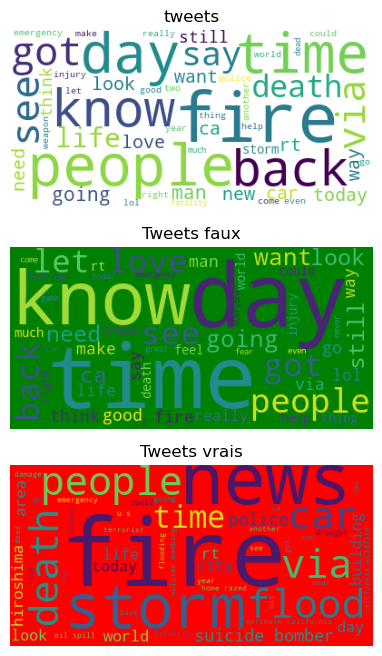

In [19]:
plt.figure(figsize=(8, 8))

plt.subplot(3, 1, 1)

wordcloud = WordCloud(background_color = 'white', stopwords = ["Û_"], max_words = 50).generate(my_lst_str)
plt.imshow(wordcloud)

plt.title('tweets')
plt.axis("off")

plt.subplot(3, 1, 2)

wordcloud_0 = WordCloud(background_color = 'green', stopwords = ["Û_"], max_words = 50).generate(my_lst_str_0)
plt.imshow(wordcloud_0)

plt.title('Tweets faux')
plt.axis("off")


plt.subplot(3, 1, 3)

wordcloud_1 = WordCloud(background_color = 'red', stopwords = ["Û_"], max_words = 50).generate(my_lst_str_1)
plt.imshow(wordcloud_1)

plt.title('Tweets vrais')
plt.axis("off")

plt.show()

## Vectorization

In [20]:
X = df['text_process']

In [21]:
tfidf = TfidfVectorizer()

In [22]:
X_vec = tfidf.fit_transform(X)

## ML : Dataset Split

In [23]:
X_train, X_val, y_train, y_val = train_test_split(X_vec, df['target'], test_size=0.2, stratify=df['target'])


## ML : SVM avec sklearn

In [24]:
#instanciation
model_1 = SVC()

## ML : Decision Tree

In [25]:
#instanciation
model_2 = DecisionTreeClassifier(max_depth = 100, random_state =0)

## ML : Random Forest

In [26]:
#instanciation
model_3 = RandomForestClassifier(max_depth = 100)

## ML : SKL Log Reg

In [27]:
#instanciation
model_4 = LogisticRegression()

## ML : xgboost

The data is stored in a DMatrix object.

In [28]:
# Create regression matrices
dtrain = xgb.DMatrix(X_train, y_train)
dval = xgb.DMatrix(X_val, y_val)

In [29]:
#instanciation
model_5 = xgb.train({'objective': 'binary:logistic', 'eval_metric': 'auc'}, dtrain, num_boost_round=10)

## Train Models

In [30]:
for model in (model_1, model_2, model_3, model_4):
    model.fit(X_train, y_train)

In [31]:
print("SCORES")
for model in (model_1, model_2, model_3, model_4):
    print(model.__class__.__name__, ":", (round(model.score(X_val, y_val) * 100, 1)))

SCORES
SVC : 79.4
DecisionTreeClassifier : 75.5
RandomForestClassifier : 77.4
LogisticRegression : 79.4


In [32]:
y_pred_total = []

for model in (model_1, model_2, model_3, model_4, model_5):
    if model.__class__.__name__ == "Booster":
        y_pred = [round(pred) for pred in model.predict(dval)]
        
    else:
        y_pred = model.predict(X_val)
    
    y_pred_total.append(y_pred)
    
    acc_score = round( accuracy_score(y_val, y_pred) * 100, 1)
    prec_score = round( precision_score(y_val, y_pred) * 100, 1)
    rec_score = round( recall_score(y_val, y_pred) * 100, 1)
    f_score = round( f1_score (y_val, y_pred) * 100, 1)
    #print( model.__class__.__name__, acc_score, prec_score, rec_score, f_score)
    
    
    print( model.__class__.__name__)
    print('Accuracy : {} | Precision : {} | Recall : {} | F1 : {}'.format(acc_score, prec_score, rec_score, f_score))
    print()
    print('--------------------------------------------------------------')

SVC
Accuracy : 79.4 | Precision : 86.5 | Recall : 60.8 | F1 : 71.4

--------------------------------------------------------------
DecisionTreeClassifier
Accuracy : 75.5 | Precision : 74.8 | Recall : 63.7 | F1 : 68.8

--------------------------------------------------------------
RandomForestClassifier
Accuracy : 77.4 | Precision : 86.6 | Recall : 55.2 | F1 : 67.4

--------------------------------------------------------------
LogisticRegression
Accuracy : 79.4 | Precision : 84.8 | Recall : 62.7 | F1 : 72.1

--------------------------------------------------------------
Booster
Accuracy : 72.5 | Precision : 87.7 | Recall : 40.8 | F1 : 55.7

--------------------------------------------------------------


In [33]:
print('--------------------------------------------------------------')    
i=-1
for model in (model_1, model_2, model_3, model_4, model_5):
    i = i + 1
    
    clf_report = classification_report(y_val, y_pred_total[i])
    
    print( model.__class__.__name__)
    print('--------------------------------------------------------------')
    print(clf_report)
    print()
    print('--------------------------------------------------------------')

--------------------------------------------------------------
SVC
--------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.76      0.93      0.84       857
           1       0.86      0.61      0.71       630

    accuracy                           0.79      1487
   macro avg       0.81      0.77      0.78      1487
weighted avg       0.81      0.79      0.79      1487


--------------------------------------------------------------
DecisionTreeClassifier
--------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.76      0.84      0.80       857
           1       0.75      0.64      0.69       630

    accuracy                           0.76      1487
   macro avg       0.75      0.74      0.74      1487
weighted avg       0.75      0.76      0.75      1487


--------------------------------------------------------------
Ra

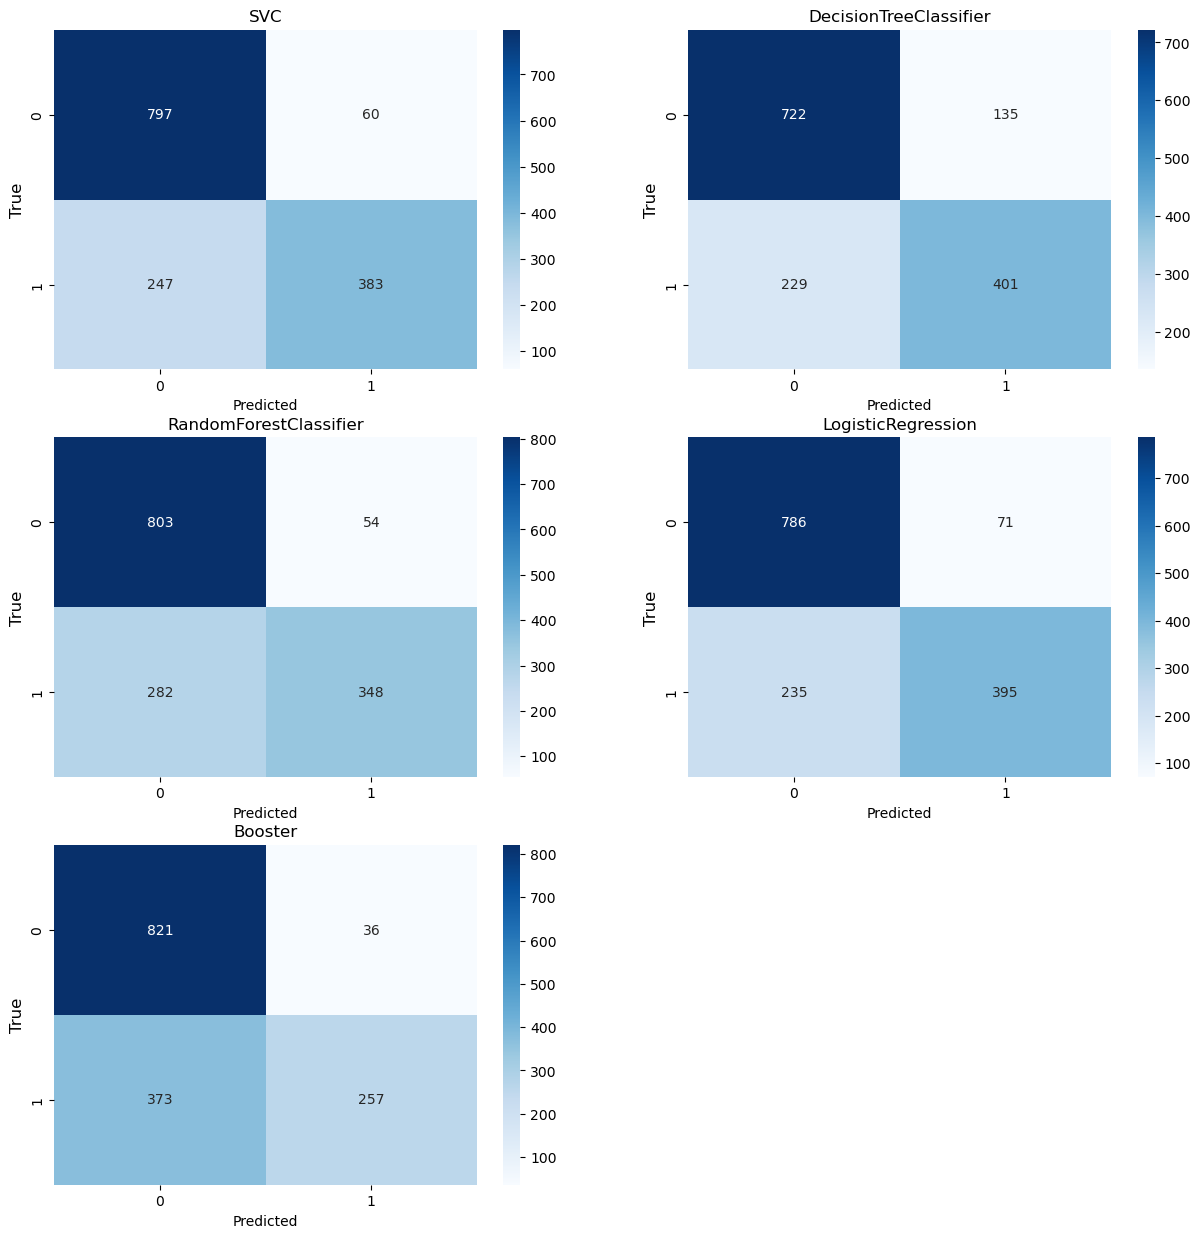

In [34]:
plt.figure(figsize=(15, 15))

plt.subplot(3, 2, 1)

cnf_matrix = confusion_matrix(y_val, y_pred_total[0])
sns.heatmap(cnf_matrix, annot=True, cmap='Blues', fmt=".0f")

plt.title(model_1.__class__.__name__)
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('True', fontsize=12)
#plt.axis("off")


plt.subplot(3, 2, 2)

cnf_matrix = confusion_matrix(y_val, y_pred_total[1])
sns.heatmap(cnf_matrix, annot=True, cmap='Blues', fmt=".0f")

plt.title(model_2.__class__.__name__)
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('True', fontsize=12)
#plt.axis("off")


plt.subplot(3, 2, 3)

cnf_matrix = confusion_matrix(y_val, y_pred_total[2])
sns.heatmap(cnf_matrix, annot=True, cmap='Blues', fmt=".0f")

plt.title(model_3.__class__.__name__)
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('True', fontsize=12)
#plt.axis("off")


plt.subplot(3, 2, 4)

cnf_matrix = confusion_matrix(y_val, y_pred_total[3])
sns.heatmap(cnf_matrix, annot=True, cmap='Blues', fmt=".0f")

plt.title(model_4.__class__.__name__)
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('True', fontsize=12)
#plt.axis("off")


plt.subplot(3, 2, 5)

cnf_matrix = confusion_matrix(y_val, y_pred_total[4])
sns.heatmap(cnf_matrix, annot=True, cmap='Blues', fmt=".0f")

plt.title(model_5.__class__.__name__)
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('True', fontsize=12)
#plt.axis("off")

plt.show()

## Prédiction -  TEST

In [35]:
def test(model, tweet):
    tw = []
    tw.append(tweet)
    #Prédiction
    X = pd.Series([tweet])
    X = tfidf.transform(X)
    
    if model.__class__.__name__ == "Booster":
        X = xgb.DMatrix(X)
        
    pred = model.predict(X)

    #affichage des résultats
    resultat = "Résultat (" + model.__class__.__name__ + "): "
    if pred[0] < 0.5:
        resultat = resultat + "NO DISASTER"
    if pred[0] >= 0.5:
        resultat = resultat + "DISASTER"
        
    return resultat

In [36]:
for model in (model_1, model_2, model_3, model_4, model_5):
    print(test(model, "Help me, my house is on fire and all the forest is burning"))

Résultat (SVC): DISASTER
Résultat (DecisionTreeClassifier): DISASTER
Résultat (RandomForestClassifier): DISASTER
Résultat (LogisticRegression): DISASTER
Résultat (Booster): DISASTER


In [37]:
for model in (model_1, model_2, model_3, model_4, model_5):
    print(test(model, "forest love"))

Résultat (SVC): NO DISASTER
Résultat (DecisionTreeClassifier): DISASTER
Résultat (RandomForestClassifier): NO DISASTER
Résultat (LogisticRegression): NO DISASTER
Résultat (Booster): NO DISASTER


In [38]:
for model in (model_1, model_2, model_3, model_4, model_5):
    print(test(model, "beautiful forest"))

Résultat (SVC): DISASTER
Résultat (DecisionTreeClassifier): DISASTER
Résultat (RandomForestClassifier): NO DISASTER
Résultat (LogisticRegression): NO DISASTER
Résultat (Booster): NO DISASTER


In [39]:
for model in (model_1, model_2, model_3, model_4, model_5):
    print(test(model, "the floor is on fire i love disco"))

Résultat (SVC): NO DISASTER
Résultat (DecisionTreeClassifier): DISASTER
Résultat (RandomForestClassifier): DISASTER
Résultat (LogisticRegression): NO DISASTER
Résultat (Booster): NO DISASTER


## Prédiction -  TEST

In [40]:
df_test = test_df.copy()

In [41]:
df_test['text_process'] = df_test['text'].apply(text_processing)

In [42]:
X_test = df_test['text_process']

In [43]:
X_test_vec = tfidf.transform(X_test)

In [44]:
test_total = []
X_test_db = xgb.DMatrix(X_test_vec)

for model in (model_1, model_2, model_3, model_4, model_5):
        
    if model.__class__.__name__ == "Booster":
        
        y_pred_test = model.predict(X_test_db)
        y_pred_test = [round(ypred) for ypred in y_pred_test]
        
    else:
    
        y_pred_test = model.predict(X_test_vec)
    
    test_total.append(y_pred_test)

In [45]:
test_total_df = pd.DataFrame(test_total).T

In [46]:
test_total_df.columns=[model.__class__.__name__ for model in [model_1, model_2, model_3, model_4, model_5]]

In [47]:
test_total_df.mean()

SVC                       0.325161
DecisionTreeClassifier    0.349678
RandomForestClassifier    0.280723
LogisticRegression        0.340484
Booster                   0.200123
dtype: float64

In [48]:
test_total_df.std()

SVC                       0.468507
DecisionTreeClassifier    0.476941
RandomForestClassifier    0.449421
LogisticRegression        0.473945
Booster                   0.400153
dtype: float64

In [49]:
test_total_df

,SVC,DecisionTreeClassifier,RandomForestClassifier,LogisticRegression,Booster
0,1,1,1,1,0
1,1,1,1,1,1
2,1,1,1,1,1
3,1,1,1,1,1
4,1,1,1,1,1
...,...,...,...,...,...
3258,1,1,1,1,1
3259,1,1,1,1,1
3260,1,1,1,1,0
3261,1,1,1,1,0
